In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
from torchvision import transforms, models, datasets
import numpy as np
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import os
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from collections import OrderedDict
import timm
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
from torch import nn

In [2]:
labels_csv = {'train': "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/image_labels_train.csv",
             'test': "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/image_labels_test.csv"
             }

data_dir = {'train': "/scratch/scratch6/akansh12/DeepEXrays/data/data_256/train/",
           'test': "/scratch/scratch6/akansh12/DeepEXrays/data/data_256/test/"}

In [3]:
labels = ['Aortic enlargement', 'Atelectasis','Calcification', 'Cardiomegaly', 'Consolidation','ILD', 'Infiltration','Lung Opacity','Nodule/Mass','Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
       'Pulmonary fibrosis', 'No finding']

In [4]:
class fourteen_class(Dataset):
    def __init__(self, label_loc, img_location, transform,  data_type= 'train'):
        label_dataframe = pd.read_csv(label_loc)
        label_dataframe.set_index("image_id", inplace = True)
        filenames = label_dataframe.index.values
        self.full_filename = [os.path.join(img_location,i+'.png') for i in filenames]
        self.labels = label_dataframe.iloc[:].values
        self.transform = transform
    def __len__(self):
        return len(self.full_filename)
    
    def __getitem__(self, idx):
        
        image = Image.open(self.full_filename[idx])
        image = self.transform(image)
        return image, self.labels[idx]
#         return image, np.expand_dims(np.array(self.labels[idx]), axis = 0)
        

data_transforms = { 
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(p = 0.5), 
        transforms.RandomPerspective(distortion_scale=0.3),
        transforms.RandomRotation((-30,30)),
        transforms.ToTensor(),
        transforms.Normalize(mean =  [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),
    
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean =  [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])        
    ])
    
}

In [5]:
train_data = fourteen_class("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/Notebooks/14_class/labels/exp_3.csv",
                                       img_location = "/scratch/scratch6/akansh12/DeepEXrays/data/data_256/train/", transform =data_transforms['train'])

test_data = fourteen_class("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/Notebooks/14_class/labels/test.csv",
                                       img_location = "/scratch/scratch6/akansh12/DeepEXrays/data/data_256/test/", transform =data_transforms['test'])

In [6]:
trainloader = DataLoader(train_data,batch_size = 4,shuffle = True)
testloader = DataLoader(test_data,batch_size = 4,shuffle = False)

In [9]:
def exp_model(path):
    model = timm.models.efficientnet_b0(pretrained=False)
    model.classifier = nn.Sequential(OrderedDict([
        ('fcl1', nn.Linear(1280,15)),
        ('out', nn.Sigmoid()),
    ]))    
    state_dict = torch.load(path, map_location = 'cpu')['state_dict']
    for keyA, keyB in zip(state_dict, model.state_dict()):
        state_dict = OrderedDict((keyB if k == keyA else k, v) for k, v in state_dict.items())

    model.load_state_dict(state_dict)
    
    return model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc

In [7]:
def calc_plot_auc_curve(model):
    model.eval()
    predicted = []
    for images,labels in tqdm(testloader):
        ps = model(images)
        predicted.extend(ps.tolist())
    plt.figure(figsize=(15,15))
    lw = 2
    labels = ['Aortic enlargement', 'Atelectasis','Calcification', 'Cardiomegaly', 'Consolidation','ILD', 'Infiltration','Lung Opacity','Nodule/Mass','Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
       'Pulmonary fibrosis', 'No finding']
    AUC = []
    for i,j in enumerate(labels):
        fpr, tpr, thresholds =  roc_curve(np.array(testloader.dataset.labels)[:,i], np.array(predicted)[:,i])
        plt.plot(fpr,tpr,lw=lw,label=f"{labels[i]} (area = {auc(fpr,tpr)})")
        AUC.append(auc(fpr,tpr))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()
    
    return AUC

### Experiment 1

In [89]:
exp_1_model = exp_model("/scratch/scratch6/akansh12/DeepEXrays/radiologist_selection/exp_1/exp_1_eff_b00.184303_15_.pth")

  0%|          | 0/750 [00:00<?, ?it/s]

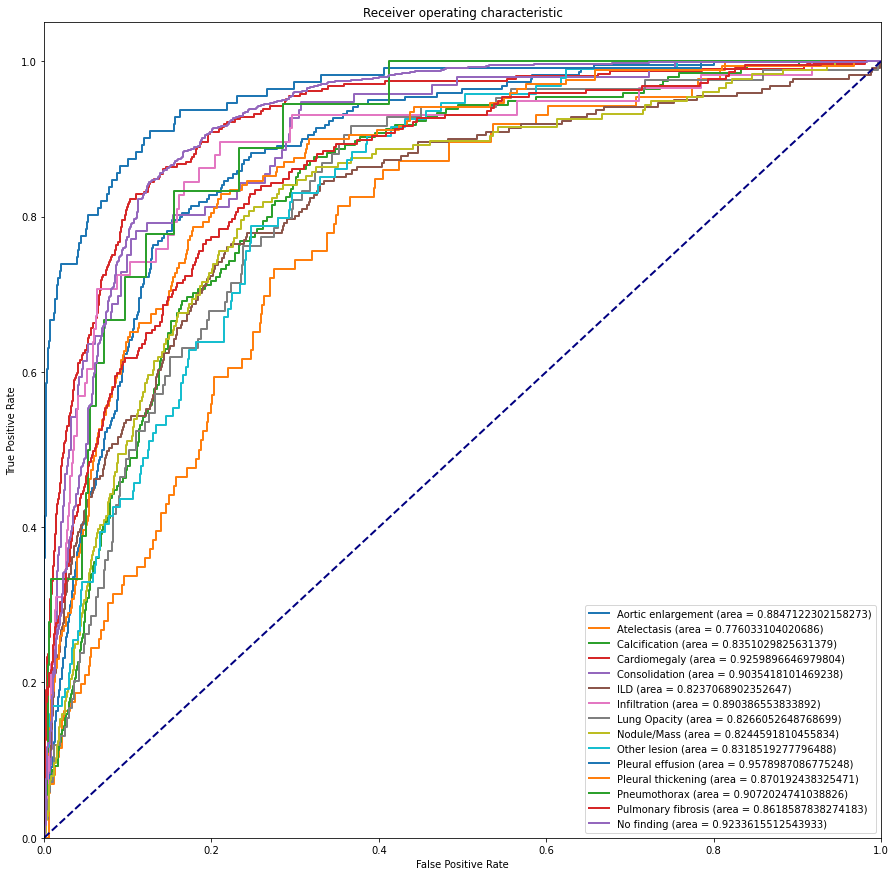

In [99]:
exp_1_auc = calc_plot_auc_curve(exp_1_model)

In [100]:
np.mean(exp_1_auc)

0.8695269043736338

### Experiment 2

In [108]:
exp_2_model = exp_model("/scratch/scratch6/akansh12/DeepEXrays/radiologist_selection/exp_2/exp_2_eff_b00.222034_23_.pth")

  0%|          | 0/750 [00:00<?, ?it/s]

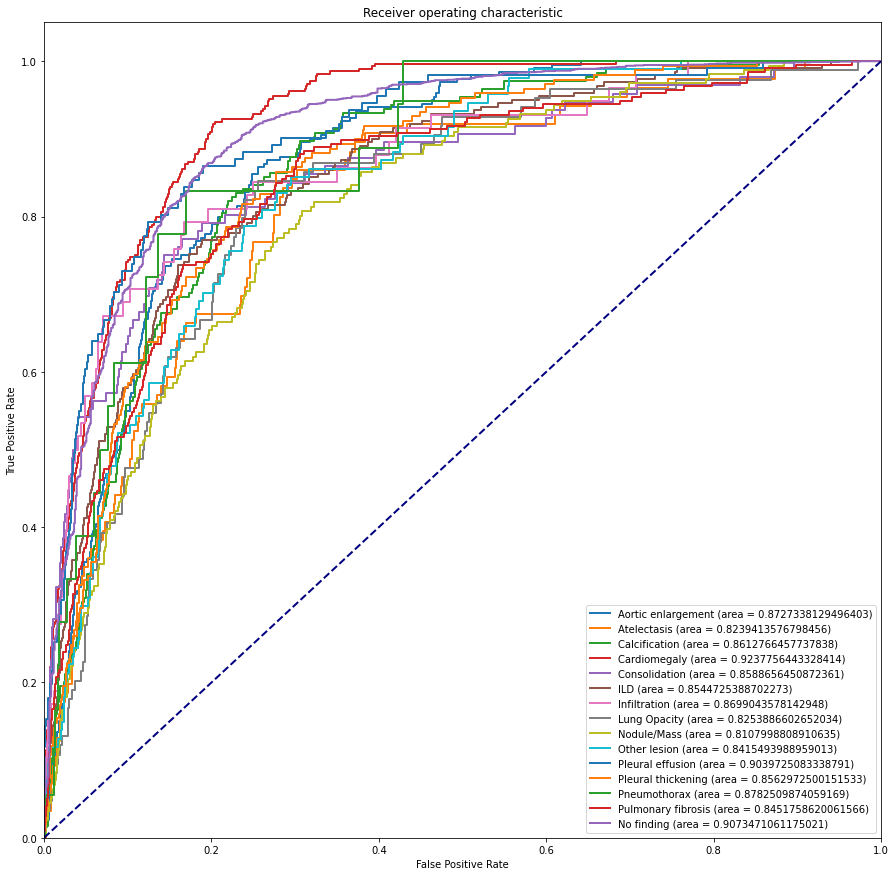

In [109]:
exp_2_auc = calc_plot_auc_curve(exp_2_model)

### Experiment 3 

In [111]:
exp_3_model = exp_model("/scratch/scratch6/akansh12/DeepEXrays/radiologist_selection/exp_3/exp_3_eff_b00.305429_13_.pth")

  0%|          | 0/750 [00:00<?, ?it/s]

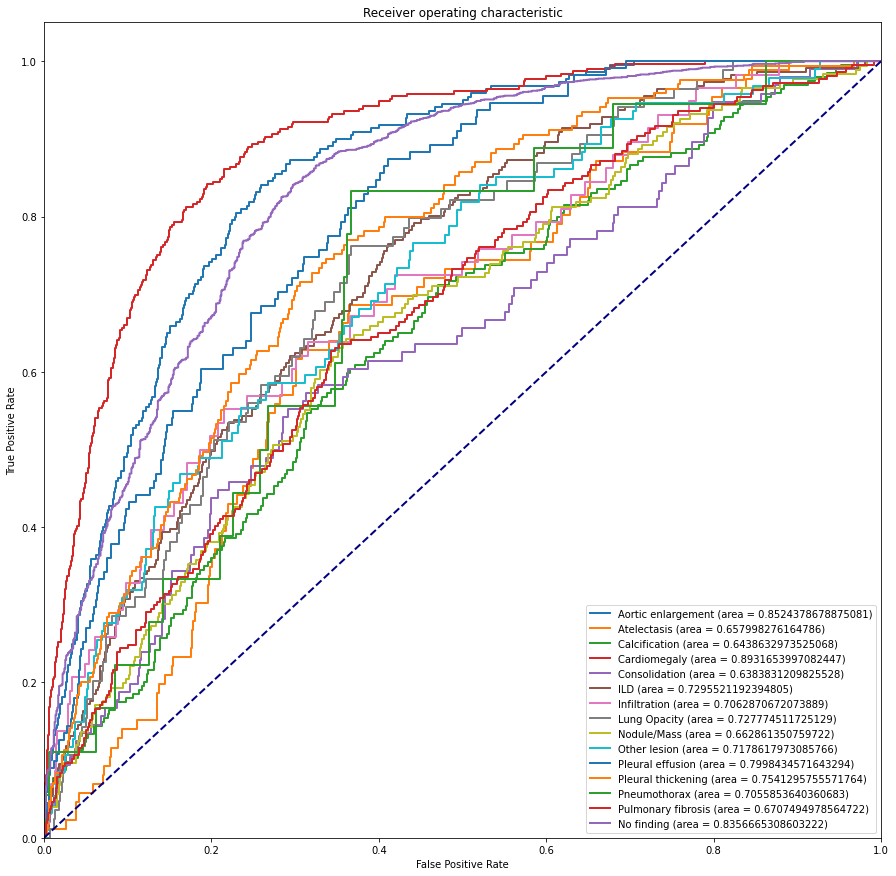

In [112]:
exp_3_auc = calc_plot_auc_curve(exp_3_model)

### Experiment 4

In [55]:
exp_4_model = exp_model("/scratch/scratch6/akansh12/DeepEXrays/radiologist_selection/exp_4/exp_4_eff_b00.205492_2_.pth")

  0%|          | 0/750 [00:00<?, ?it/s]

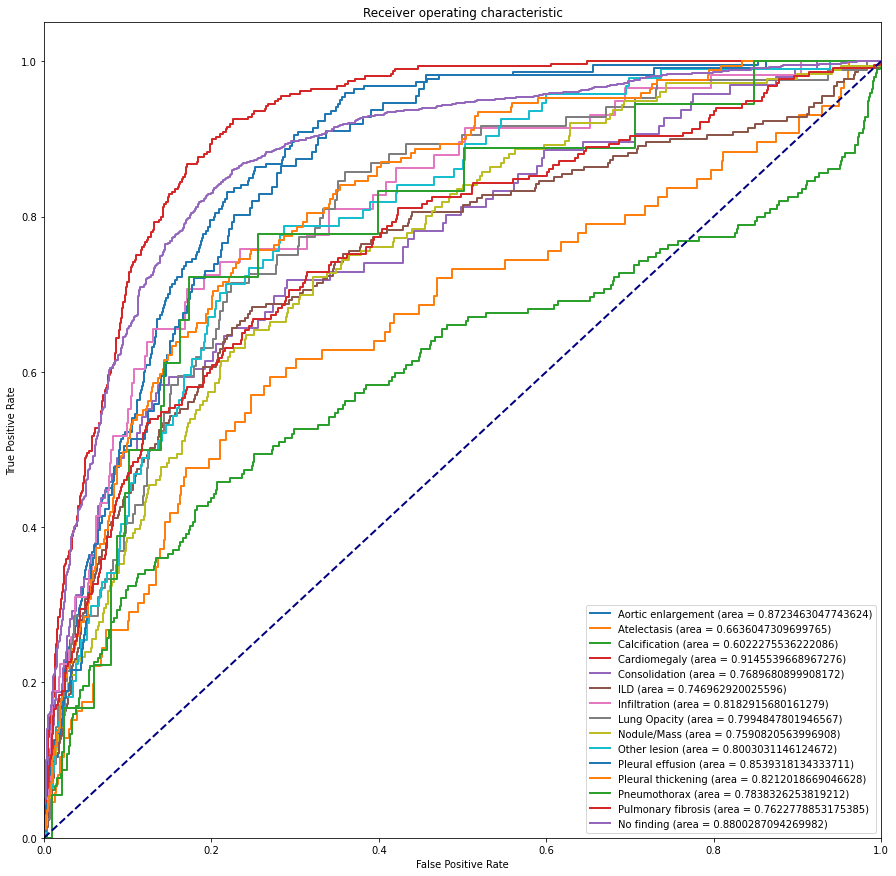

In [56]:
exp_4_auc = calc_plot_auc_curve(exp_4_model)

### Experiment 5 

In [101]:
exp_5_model = exp_model("/scratch/scratch6/akansh12/DeepEXrays/radiologist_selection/exp_5/exp_5_eff_b00.183247_20_.pth")

  0%|          | 0/750 [00:00<?, ?it/s]

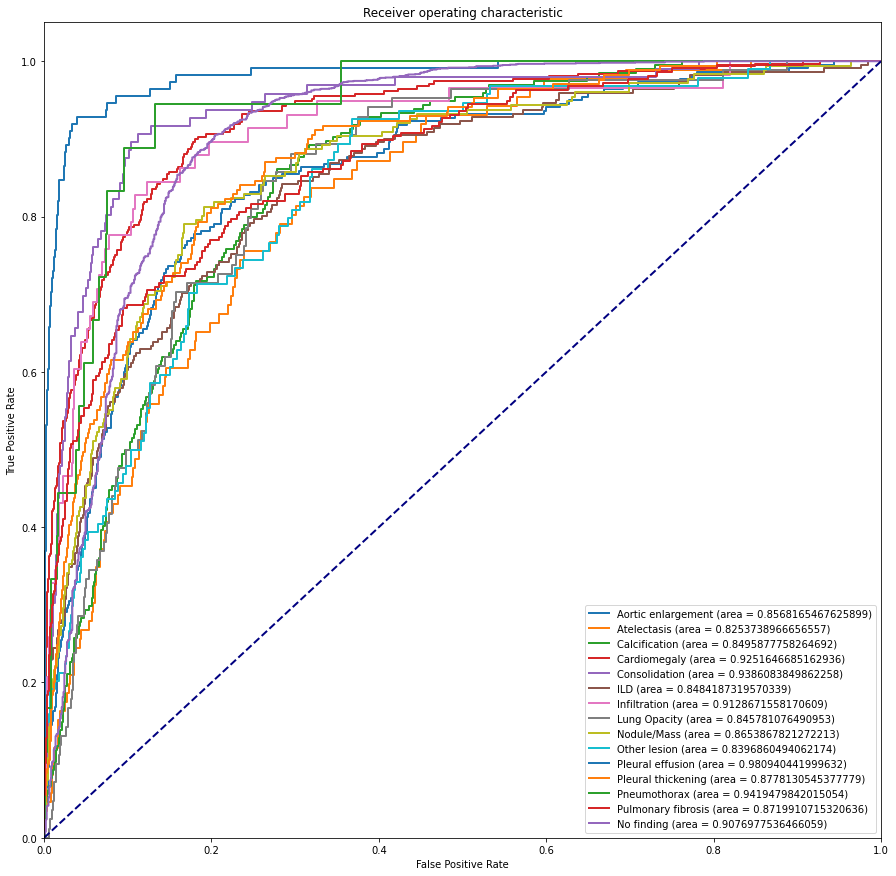

In [102]:
exp_5_auc = calc_plot_auc_curve(exp_5_model)

In [113]:
np.mean(exp_5_auc)

0.8858720916315537

### Experiment 6

In [54]:
exp_6_model = exp_model("/scratch/scratch6/akansh12/DeepEXrays/radiologist_selection/final/fnal_eff_b00.169718_4_0.8737685450167315_.pth")

  0%|          | 0/750 [00:00<?, ?it/s]

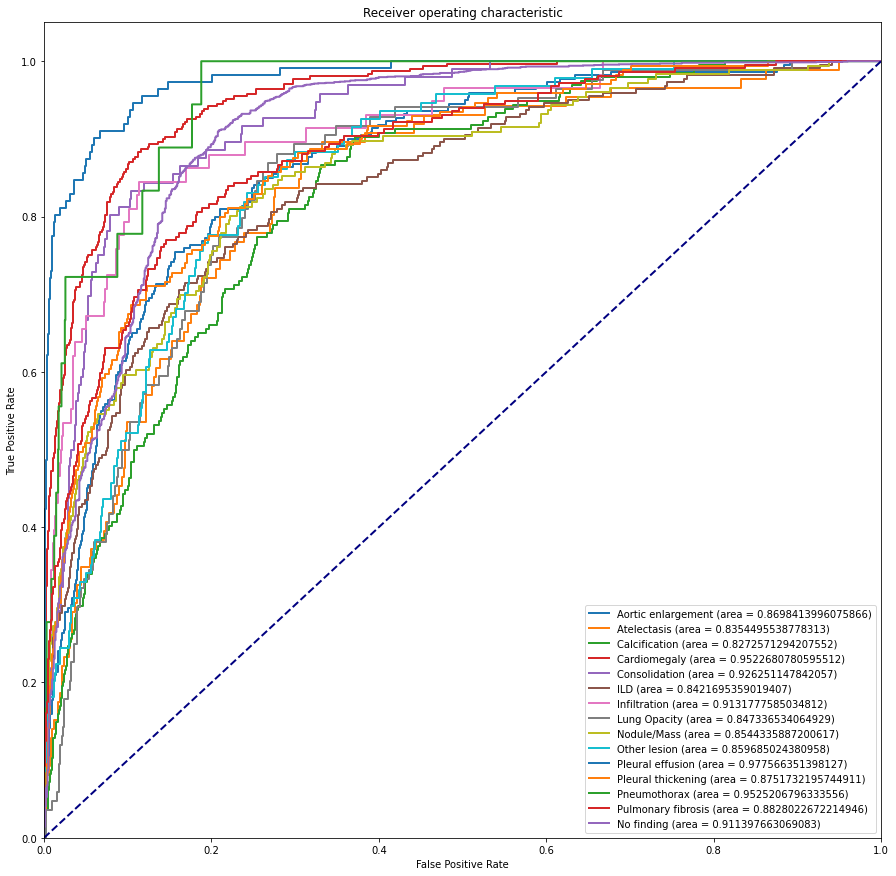

In [11]:
exp_6_auc = calc_plot_auc_curve(exp_6_model)

In [ ]:
exp_6_auc = calc_plot_auc_curve(exp_6_model)

In [12]:
columns = ['Experiment', 'Mean AUC']

In [13]:
columns.extend(labels)

In [14]:
result_df = pd.DataFrame(columns=columns)

In [15]:
result_df['Experiment'] = [1,2,3,4,5,6]

In [16]:
result_df.set_index('Experiment', inplace = True)

In [ ]:
result_df.loc[1][labels] = exp_1_auc
result_df.loc[1]['Mean AUC'] = np.mean(exp_1_auc) 

result_df.loc[2][labels] = exp_2_auc
result_df.loc[2]['Mean AUC'] = np.mean(exp_2_auc) 

result_df.loc[3][labels] = exp_3_auc
result_df.loc[3]['Mean AUC'] = np.mean(exp_3_auc) 

result_df.loc[4][labels] = exp_4_auc
result_df.loc[4]['Mean AUC'] = np.mean(exp_4_auc) 

result_df.loc[5][labels] = exp_5_auc
result_df.loc[5]['Mean AUC'] = np.mean(exp_5_auc) 

result_df.loc[6][labels] = exp_6_auc
result_df.loc[6]['Mean AUC'] = np.mean(exp_6_auc) 


In [ ]:
result_df

In [121]:
result_df.T

Experiment,1,2,3,4,5
Mean AUC,0.869527,0.86225,0.733077,0.789807,0.885872
Aortic enlargement,0.884712,0.872734,0.852438,0.872346,0.856817
Atelectasis,0.776033,0.823941,0.657998,0.663605,0.825374
Calcification,0.835103,0.861277,0.643863,0.602228,0.849588
Cardiomegaly,0.92599,0.923776,0.893165,0.914554,0.925165
Consolidation,0.903542,0.858866,0.638383,0.768968,0.938608
ILD,0.823707,0.854473,0.729552,0.746963,0.848419
Infiltration,0.890387,0.869904,0.706287,0.818292,0.912867
Lung Opacity,0.826605,0.825389,0.727775,0.799485,0.845781
Nodule/Mass,0.824459,0.8108,0.662861,0.759082,0.865387


## Final Model Results/Experiment 6

In [55]:
exp_6_model.eval()
predicted = []
for images,labels in tqdm(testloader):
        ps = exp_6_model(images)
        predicted.extend(ps.tolist())

  0%|          | 0/750 [00:00<?, ?it/s]

In [26]:
np.array(predicted)[:,0] > 0.5

array([False, False, False, ..., False, False, False])

In [28]:
testloader.dataset.labels[:,0]

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
    model.eval()
    predicted = []
    for images,labels in tqdm(testloader):
        ps = model(images)
        predicted.extend(ps.tolist())
    plt.figure(figsize=(15,15))
    lw = 2
    labels = ['Aortic enlargement', 'Atelectasis','Calcification', 'Cardiomegaly', 'Consolidation','ILD', 'Infiltration','Lung Opacity','Nodule/Mass','Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
       'Pulmonary fibrosis', 'No finding']
    AUC = []
    for i,j in enumerate(labels):
        fpr, tpr, thresholds =  roc_curve(np.array(testloader.dataset.labels)[:,i], np.array(predicted)[:,i])
        plt.plot(fpr,tpr,lw=lw,label=f"{labels[i]} (area = {auc(fpr,tpr)})")
        AUC.append(auc(fpr,tpr))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()
    

In [84]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(testloader.dataset.labels[:,3], np.array(predicted)[:,3] > 0.41).ravel()
specificity = tn / (tn+fp)

In [85]:
specificity

0.9795615013006317

In [86]:
sensitivity = tp/(tp+fn)

In [87]:
sensitivity

0.4174757281553398

In [90]:
exp_1_model.eval()
predicted = []
for images,labels in tqdm(testloader):
        ps = exp_1_model(images)
        predicted.extend(ps.tolist())

  0%|          | 0/750 [00:00<?, ?it/s]

In [101]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(testloader.dataset.labels[:,-5], np.array(predicted)[:,-5] > 0.5).ravel()
specificity = tn / (tn+fp)

print(specificity)
print(sensitivity)

0.9390792661820699
0.4174757281553398


In [102]:
accuracy = (tp+tn)/(tp+tn+fp+fn)

In [103]:
print(accuracy)

0.9336666666666666


In [96]:
!ls /scratch/scratch6/akansh12/DeepEXrays/radiologist_selection/exp_7

fnal_eff_b00.170795_2_0.8396513742573735_.pth
fnal_eff_b00.174443_1_0.8191757456951011_.pth
fnal_eff_b00.184320_3_0.8644106321192757_.pth
fnal_eff_b00.231288_0_0.7989844504800185_.pth
